In [1]:
# importing libraries

import os
import gc
import cv2
import math
import json
import glob
import scipy
import random
import itertools

import numpy as np
import pandas as pd
import xgboost as xgb


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from functools import partial
from numpy import expand_dims
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [2]:
# function to load images from the directory
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []

    def read(imname):
        return np.asarray(Image.open(imname).convert("L"))

    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE, RESIZE))
            IMG.append(np.array(img))
    return IMG

In [3]:
# calling functions 
benign_train = np.array(Dataset_loader('../input/dataset/train/Normal',100))
malign_train = np.array(Dataset_loader('../input/dataset/train/OSCC',100))
benign_test = np.array(Dataset_loader('../input/dataset/test/Normal',100))
malign_test = np.array(Dataset_loader('../input/dataset/test/OSCC',100))
benign_val = np.array(Dataset_loader('../input/dataset/val/Normal',100))
malign_val = np.array(Dataset_loader('../input/dataset/val/OSCC',100))

100%|██████████| 92/92 [00:14<00:00,  6.37it/s]


In [4]:
# creating empty to store the datasets
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

benign_val_label = np.zeros(len(benign_val))
malign_val_label = np.ones(len(malign_val))


In [5]:
# Merge dataset
X_train = np.concatenate((benign_train, malign_train), axis=0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis=0)
X_test = np.concatenate((benign_test, malign_test), axis=0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis=0)

X_val = np.concatenate((benign_val, malign_val), axis=0)
Y_val = np.concatenate((benign_val_label, malign_val_label), axis=0)

In [6]:
# reinitialising train and test dataset
x_train = X_train
x_val = X_val
y_train = Y_train
y_val = Y_val

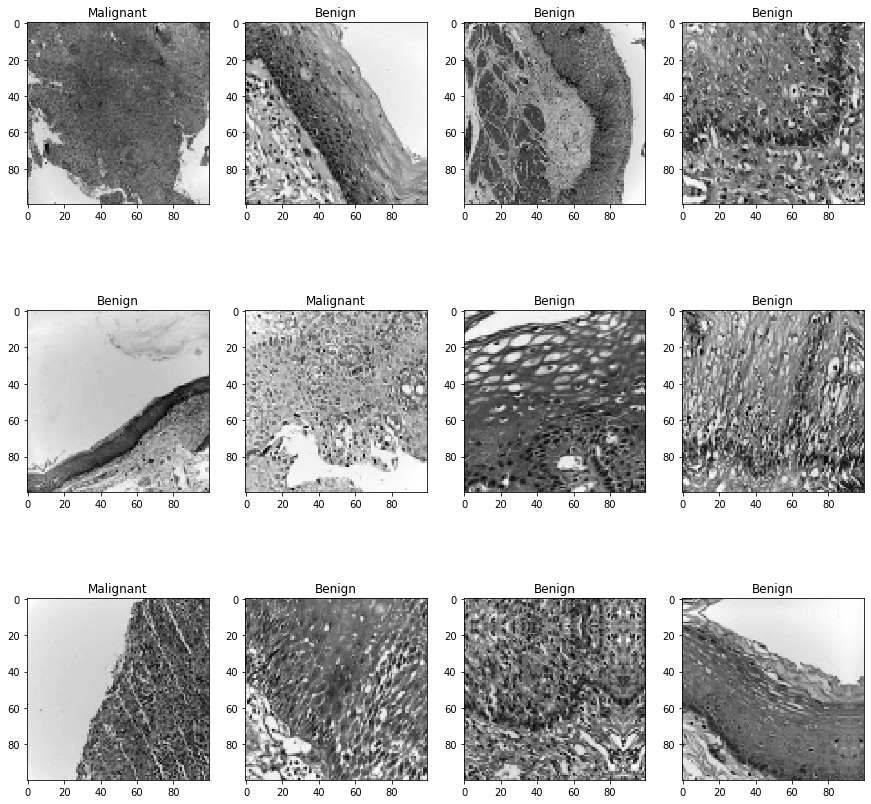

In [7]:
# displaying random images
import random
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    idx = random.randint(1, 4500)
    #print(Y_train[idx])
    if int(Y_train[idx]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[idx], interpolation='nearest', cmap='gray')
plt.show()

In [8]:
# printing the dataset shape
x_train.shape, x_val.shape,X_test.shape

((4946, 100, 100), (120, 100, 100), (126, 100, 100))

In [9]:
# reshaping image dataset into 1D array
x_train = x_train.reshape(4946, 10000)
x_val = x_val.reshape(120, 10000)
X_test = X_test.reshape(126, 10000)

In [10]:
# defining Decision tree classifier
treeModel = DecisionTreeClassifier()

In [11]:
# defining Xg boosting classifier
xgbModel = xgb.XGBRFClassifier(learning_rate=0.1, n_estimators=10)

In [12]:
# training Decision tree classifier
treeModel.fit(x_train, y_train)

DecisionTreeClassifier()

In [13]:
# training Xg boosting classifier
xgbModel.fit(x_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=10,
                n_jobs=0, num_parallel_tree=10, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                sampling_method='uniform', ...)

In [14]:
# evaluating decision tree
score = treeModel.score(X_test, Y_test)
print('Accuracy Decision Tree', score)

Accuracy Decision Tree 0.6111111111111112


In [15]:
# evaluating xg boosting
score = xgbModel.score(X_test, Y_test)
print('Accuracy XG Boosting', score)

Accuracy XG Boosting 0.6428571428571429


In [16]:
# predicting labels for the test data
treeModelPreds = treeModel.predict(X_test)
xgbModelPreds = xgbModel.predict(X_test)

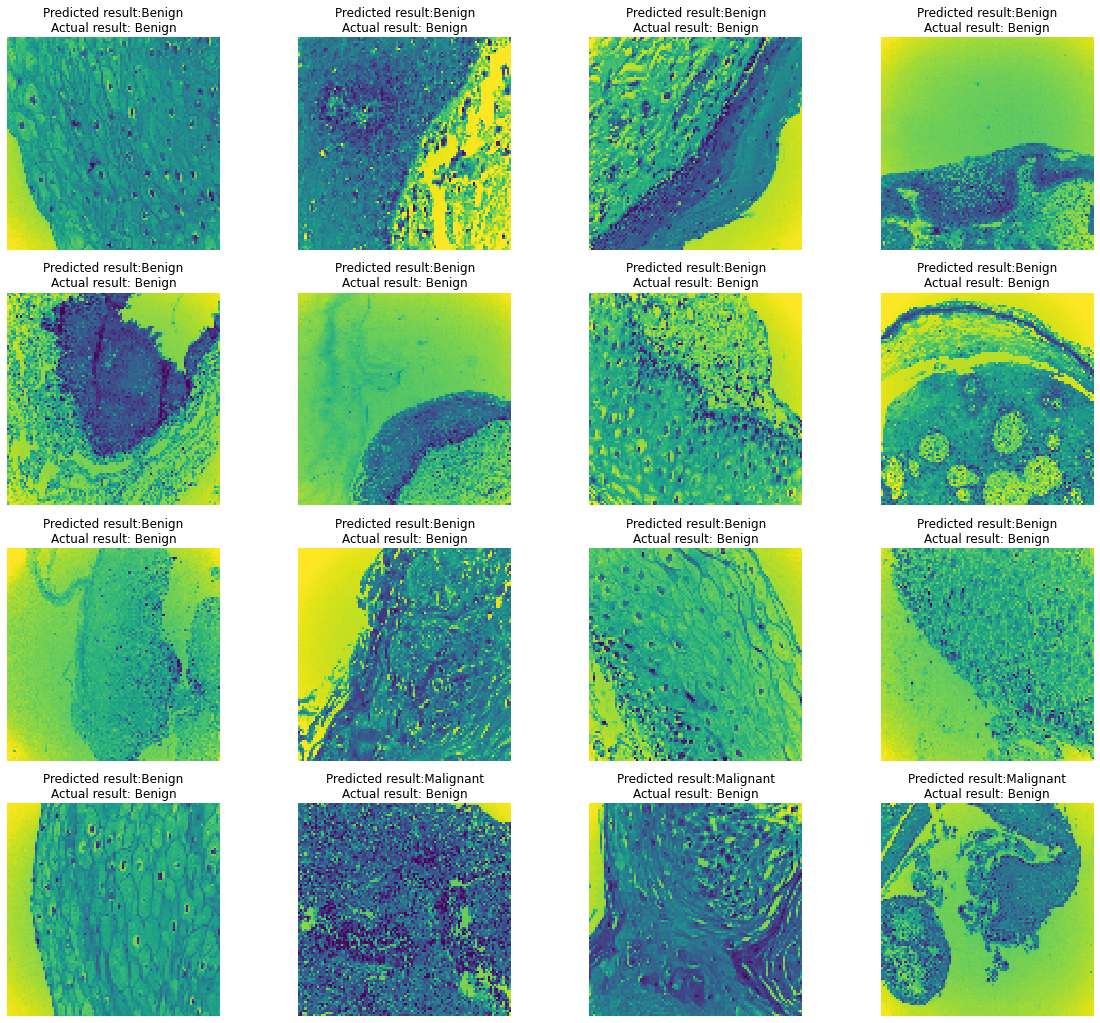

In [30]:
# comparing predicted and actual labels for decision tree
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if (Y_test[i] == treeModelPreds[i]):
        prop_class.append(i)
    if (len(prop_class) == 16):
        break

i = 0
for i in range(len(Y_test)):
    if (not Y_test[i] == treeModelPreds[i]):
        mis_class.append(i)
    if (len(mis_class) == 16):
        break

w = 60
h = 40
fig = plt.figure(figsize=(20, 18))
columns = 4
rows = 4


def Transfername(namecode):
    if int(namecode) == 0:
        return "Benign"
    else:
        return "Malignant"


for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title("Predicted result:" +
                 Transfername(treeModelPreds[prop_class[i]]) + "\n" +
                 "Actual result: " +
                 Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]].reshape((100, 100)),
               interpolation='nearest')
    plt.axis('off')
plt.show()

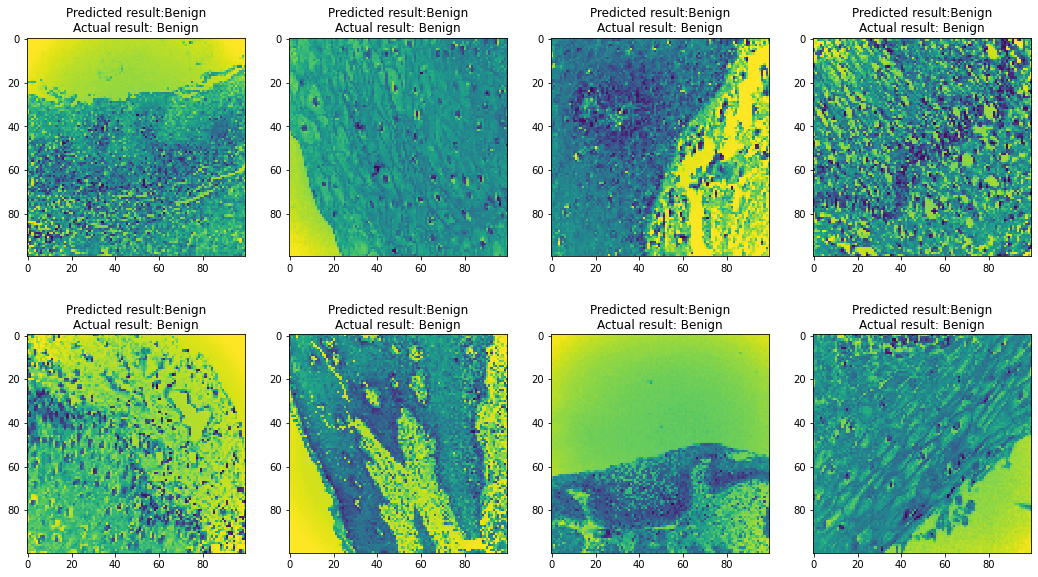

In [18]:
# comparing predicted and actual labels for XG Boosting
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if (Y_test[i] == xgbModelPreds[i]):
        prop_class.append(i)
    if (len(prop_class) == 8):
        break

i = 0
for i in range(len(Y_test)):
    if (not Y_test[i] == xgbModelPreds[i]):
        mis_class.append(i)
    if (len(mis_class) == 8):
        break

w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2


def Transfername(namecode):
    if namecode == 0:
        return "Benign"
    else:
        return "Malignant"


for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title("Predicted result:" +
                 Transfername(xgbModelPreds[prop_class[i]]) + "\n" +
                 "Actual result: " +
                 Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]].reshape((100, 100)),
               interpolation='nearest')
plt.show()

In [22]:
treeModelPreds

array([1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0.])

In [23]:
Y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])